# Script to correct the closed orbit in `cpymad` AKA `MAD-X`

In [1]:
# Load helper scripts
%run ../../Scripts/helper_functions.py
%run ../../Scripts/cpymad_helpers.py
%run ../../Scripts/cpymad_closed_orbit_matching_functions.py
%run ../../Scripts/ISIS_tune_control_functions.py
%run ../../Scripts/cpymad_2025_orbit_methods.py

In [2]:
import pandas as pd
from datetime import datetime

class cpymad_ErrorTableBuilder:
    def __init__(self, twiss_df):
        """
        Initialize the error table builder with a MAD-X twiss table DataFrame.
        """
        self.twiss_df = twiss_df.copy()
        self.error_df = pd.DataFrame(columns=["NAME", "DX", "DY", "DS", "DPHI", "DTHETA", "DPSI", "S"])

    def match_main_magnet_parts(self, base_name):
        """
        Return a list of element names matching base_name (e.g. 'sp6_qf'), 
        excluding fringe-like variants and stripping colon suffixes.
        """
        names = self.twiss_df['name'].astype(str)
        matched = names[
            names.str.startswith(base_name) &
            names.str.len().ge(len(base_name)) &
            names.str[len(base_name)].isin(['_', ':'])
        ]
        return matched.str.split(':').str[0].unique().tolist()      

    def add_dipole_misalignment(self, base_name, misalignment_type, value_mm):
        """
        Add a misalignment value (in mm or mrad) for all parts of a dipole element.
    
        Parameters:
            - base_name: base name of dipole (e.g. "sp6_dip")
            - misalignment_type: one of "DX", "DY", "DS", "DPHI", "DTHETA", "DPSI"
            - value_mm: value in mm or mrad (e.g. 1.5 for 1.5 mm)
        """
        misalignment_type = misalignment_type.upper()
        assert misalignment_type in ["DX", "DY", "DS", "DPHI", "DTHETA", "DPSI"], f"Invalid type {misalignment_type}"
    
        names = self.twiss_df['name'].astype(str)
        matched = names[names.str.startswith(base_name)]
        parts = matched.str.split(":").str[0].unique().tolist()
    
        # Prepare Twiss lookup with cleaned names (without colon suffixes)
        twiss_lookup = (
            self.twiss_df.copy()
            .assign(name_clean=self.twiss_df["name"].astype(str).str.split(":").str[0])
            .drop_duplicates(subset="name_clean")
            .set_index("name_clean")["s"]
        )
    
        for name in parts:
            match = self.error_df["NAME"] == name
            if match.any():
                self.error_df.loc[match, misalignment_type] = float(value_mm)
            else:
                try:
                    s_val = float(twiss_lookup.get(name))
                except Exception:
                    s_val = float("inf")
    
                columns = ["NAME", "DX", "DY", "DS", "DPHI", "DTHETA", "DPSI", "S"]
                row_full = {col: 0.0 for col in columns}
                row_full.update({
                    "NAME": name,
                    misalignment_type: float(value_mm),
                    "S": s_val
                })
                self.error_df = pd.concat([self.error_df, pd.DataFrame([row_full])], ignore_index=True)

        
    def add_quadrupole_misalignment(self, base_name, misalignment_type, value_mm):
        """
        Add a misalignment value (in mm or mrad) for all parts of a given magnet.
        
        Parameters:
            - base_name: base name of magnet (e.g. "sp6_qf")
            - misalignment_type: one of "DX", "DY", "DS", "DPHI", "DTHETA", "DPSI"
            - value_mm: value in mm or mrad (e.g. 1.5 for 1.5 mm)
        """
        misalignment_type = misalignment_type.upper()
        assert misalignment_type in ["DX", "DY", "DS", "DPHI", "DTHETA", "DPSI"], f"Invalid type {misalignment_type}"
        parts = self.match_main_magnet_parts(base_name)
        
        # Prepare Twiss lookup with cleaned names (without colon suffixes)
        twiss_lookup = (
            self.twiss_df.copy()
            .assign(name_clean=self.twiss_df["name"].astype(str).str.split(":").str[0])
            .drop_duplicates(subset="name_clean")
            .set_index("name_clean")["s"]
        )
    
        for name in parts:
            match = self.error_df["NAME"] == name
            if match.any():
                # Update existing row
                self.error_df.loc[match, misalignment_type] = float(value_mm)
            else:
                # Add new row
                try:
                    s_val = float(twiss_lookup.get(name))
                except Exception:
                    s_val = float("inf")
    
                row = {
                    "NAME": name,
                    "DX": 0.0,
                    "DY": 0.0,
                    "DS": 0.0,
                    "DPHI": 0.0,
                    "DTHETA": 0.0,
                    "DPSI": 0.0,
                    "S": s_val
                }
                columns = ["NAME", "DX", "DY", "DS", "DPHI", "DTHETA", "DPSI", "S"]
                row_full = {col: 0.0 for col in columns}
                row_full.update({
                    "NAME": name,
                    misalignment_type: float(value_mm),
                    "S": s_val
                })
                self.error_df = pd.concat([self.error_df, pd.DataFrame([row_full])], ignore_index=True)


    def save_to_tfs(self, filename, origin=None):
        from datetime import datetime
        now = datetime.now()
        date_str = now.strftime("%d/%m/%y")
        time_str = now.strftime("%H.%M.%S")
        if origin is None:
            origin = "cpymad"
    
        header_lines = [
            '@ NAME             %06s "EFIELD"',
            '@ TYPE             %06s "EFIELD"',
            '@ TITLE            %08s "no-title"',
            f'@ ORIGIN           %16s "{origin}"',
            f'@ DATE             %08s "{date_str}"',
            f'@ TIME             %08s "{time_str}"',
        ]
    
        # Exact MAD-X column order
        col_names = []
        for i in range(21):
            col_names.append(f'K{i}L')
            col_names.append(f'K{i}SL')
        col_names += [
            'DX', 'DY', 'DS', 'DPHI', 'DTHETA', 'DPSI',
            'MREX', 'MREY', 'MREDX', 'MREDY', 'AREX', 'AREY',
            'MSCALX', 'MSCALY', 'RFM_FREQ', 'RFM_HARMON', 'RFM_LAG'
        ]
        for i in range(21):
            col_names.append(f'P{i}L')
            col_names.append(f'P{i}SL')
    
        # Exact formatting for header and type lines
        col_headers = "* NAME                        " + " ".join(f"{col:<12}" for col in col_names)
        col_types = "$ %s                          " + " ".join("%le".rjust(12) for _ in col_names)
    
        df = self.error_df.copy().sort_values("S", na_position="last")
        if "S" in df.columns:
            df = df.drop(columns=["S"])
    
        with open(filename, "w") as f:
            for line in header_lines:
                f.write(line + "\n")
            f.write(col_headers + "\n")
            f.write(col_types + "\n")
    
            for _, row in df.iterrows():
                name = f'"{row["NAME"].upper()}"'
                line = f' {name:<28}'
    
                for col in col_names:
                    val = row.get(col, 0.0)
                    try:
                        num = float(val)
                    except Exception:
                        num = 0.0
    
                    if col in ['DX', 'DY', 'DS']:
                        num *= 1e-3  # mm → m
                    elif col in ['DPHI', 'DTHETA', 'DPSI']:
                        num *= 1e-3  # mrad → rad
    
                    line += f"{num:.12f} "
    
                f.write(line.rstrip() + "\n")
    
    def add_misalignments_from_dataframe(self, df):
        """
        Process a DataFrame with survey data and apply DY and DPSI misalignments.
    
        Expected columns:
        - magnet, S_start, S_end, S_centre, angle, offset_start, offset_end, offset_centre
    
        Rules:
        - 'Dipole #' → calls add_dipole_misalignment("sp#_dip", ...)
        - 'QD #'     → calls add_quadrupole_misalignment("sp#_qd", ...)
        - 'QF #'     → calls add_quadrupole_misalignment("sp#_qf", ...)
        - 'QC #'     → calls add_quadrupole_misalignment("sp#_qds", ...)
        """
        def map_name_and_type(magnet):
            if magnet.startswith("Dipole "):
                return f"sp{magnet.split()[-1]}_dip", "dipole"
            elif magnet.startswith("QD "):
                return f"sp{magnet.split()[-1]}_qd", "quad"
            elif magnet.startswith("QF "):
                return f"sp{magnet.split()[-1]}_qf", "quad"
            elif magnet.startswith("QC "):
                return f"sp{magnet.split()[-1]}_qds", "quad"
            else:
                raise ValueError(f"Unrecognised magnet label: {magnet}")
    
        df = df.copy()
        df[["name", "type"]] = df["magnet"].apply(lambda m: pd.Series(map_name_and_type(m)))
    
        for _, row in df.iterrows():
            dy = row["offset_centre"]
            dpsi = row["angle"]
            if row["type"] == "dipole":
                self.add_dipole_misalignment(row["name"], "DY", dy)
                self.add_dipole_misalignment(row["name"], "DPSI", dpsi)
            else:
                self.add_quadrupole_misalignment(row["name"], "DY", dy)
                self.add_quadrupole_misalignment(row["name"], "DPSI", dpsi)

In [3]:
def cpymad_apply_and_check_error_table(madx_instance, error_file, original_df, atol=1e-10, rtol=1e-12):
    """
    Apply the error table to MAD-X, extract the resulting table, and compare with the original error_df.

    Parameters:
        madx_instance : cpymad.madx.Madx
            Active MAD-X instance.
        error_file : str
            Path to the .tfs error table file.
        original_df : pd.DataFrame
            The builder.error_df to compare against (values in mm/mrad).
        atol : float
            Absolute tolerance for comparison (default: 1e-10).
        rtol : float
            Relative tolerance for comparison (default: 1e-12).

    Returns:
        bool
            True if the tables match within tolerance, otherwise raises AssertionError.
    """
    # Apply error table
    cpymad_apply_error_table(madx_instance, error_file)

    # Get MAD-X table in m/rad
    madx_df = get_madx_table_df(madx_instance, nonzero=False)
    madx_df = madx_df[["name", "dx", "dy", "ds", "dphi", "dtheta", "dpsi"]].copy()
    madx_df["name"] = madx_df["name"].str.lower()

    # Scale original_df from mm/mrad → m/rad
    original = original_df[["NAME", "DX", "DY", "DS", "DPHI", "DTHETA", "DPSI"]].copy()
    original.columns = [c.lower() for c in original.columns]
    original["name"] = original["name"].str.lower()

    for col in ["dx", "dy", "ds", "dphi", "dtheta", "dpsi"]:
        original[col] = original[col].astype(float) * 1e-3

    # Sort both DataFrames
    madx_sorted = madx_df.sort_values("name").reset_index(drop=True)
    original_sorted = original.sort_values("name").reset_index(drop=True)

    # Compare with tolerance
    pd.testing.assert_frame_equal(madx_sorted, original_sorted, check_dtype=False, rtol=rtol, atol=atol)
    return True


In [4]:
def cpymad_apply_error_table(madx_instance, error_table_file):
    """
    Apply a MAD-X error table file using madx_instance.input().

    Parameters:
        madx_instance: The cpymad.Madx instance.
        error_table_file: Path to the .tfs error table file.
    """
    madx_instance.input(f'READMYTABLE, file="{error_table_file}", table=efield;')
    madx_instance.input('SETERR, TABLE=efield;')

In [5]:
def get_madx_table_df(madx, table_name="efield", nonzero=True):
    """
    Extracts a MAD-X table as a pandas DataFrame.

    Parameters:
        madx : cpymad.madx.Madx
            The active MAD-X instance.
        table_name : str
            Name of the MAD-X table to extract (default: "efield").
        nonzero : bool
            If True, return only rows where any of the key misalignment/rotation columns are non-zero.

    Returns:
        pd.DataFrame
            DataFrame containing the filtered or full table data.
    """
    if table_name not in list(madx.table):
        raise ValueError(f"MAD-X table '{table_name}' not found. Available tables: {list(madx.table)}")

    raw_table = getattr(madx.table, table_name)
    raw_data = raw_table.copy()
    df = pd.DataFrame(raw_data, columns=raw_data.keys())

    if nonzero:
        cols = ["ds", "dx", "dy", "dtheta", "dphi", "dpsi"]
        df = df[(df[cols] != 0).any(axis=1)][["name"] + cols]

    return df

In [6]:
import pandas as pd

class BPMFitResultsLoader:
    def __init__(self, filepath, reverse_co=False):
        self.filepath = filepath
        self.reverse_co = reverse_co
        self.df = self._load_file()
        
    def _load_file(self):
        return pd.read_csv(self.filepath, sep=r"\s+")
    
    def get_bpm_list(self):
        return self.df['bpm'].unique().tolist()

    def get_available_parameters(self):
        return self.df.columns

    def get_parameter(self, param_name, bpm=None):
        if param_name not in self.df.columns:
            raise ValueError(f"Parameter '{param_name}' not found in data.")
        if bpm:
            return self.df[self.df['bpm'] == bpm][param_name].values
        return self.df[param_name].values

    def get_plane_parameters(self, plane="H", parameters=None):
        if parameters is None:
            parameters = self.get_available_parameters()
        missing = [p for p in parameters if p not in self.df.columns]
        if missing:
            raise ValueError(f"Missing parameters in file: {missing}")
        df_plane = self.df[self.df['plane'] == plane].copy()
        return df_plane[["bpm"] + parameters]

    def get_co_data(self, plane="H", twiss_df=None):
        required_columns = ["closed_orbit_mm", "closed_orbit_mm_err"]
        missing = [col for col in required_columns if col not in self.df.columns]
        if missing:
            raise ValueError(f"Missing required CO data columns: {missing}")
        
        df_plane = self.df[self.df['plane'] == plane].copy()
    
        if self.reverse_co:
            df_plane["closed_orbit_mm"] *= -1
    
        # Optional Twiss 's' lookup by partial BPM name
        if twiss_df is not None:
            twiss_lookup = twiss_df.copy()
            twiss_lookup["name_stripped"] = twiss_lookup["name"].astype(str).str.lower()
            bpm_to_s = {}
    
            for bpm in df_plane["bpm"]:
                bpm_key = bpm.lower()
                matched = twiss_lookup[twiss_lookup["name_stripped"].str.contains(bpm_key)]
                if len(matched) == 1:
                    bpm_to_s[bpm] = matched["s"].values[0]
                else:
                    bpm_to_s[bpm] = float("nan")  # ambiguous or not found
    
            df_plane["s"] = df_plane["bpm"].map(bpm_to_s)
    
        return df_plane[["bpm", "closed_orbit_mm", "closed_orbit_mm_err"] + (["s"] if "s" in df_plane.columns else [])]

    def get_dataframe(self):
        return self.df

In [7]:
def cpymad_set_correctors(madx_instance, cpymad_logfile, corrector_dict, max_E=800., time=0.0):
    """
    Applies the vertical corrector kick values (converted from Amperes to mrad) 
    to a cpymad MAD-X instance.

    Parameters:
    madx_instance (Madx): An instance of cpymad's MAD-X.
    cpymad_logfile (str): Path to the cpymad log file (not used in function).
    corrector_dict (dict): Dictionary with keys as MAD-X variable names 
                           and values as the programmed kicks in Amperes.
    """

    for key, amps in corrector_dict.items():
        # Extract plane ('V' from 'vd1') and super-period (from 'rX' where X is 0, 2, etc.)
        sp = int(key[1])  # Extract the second character as the super-period
        plane = 'V' if 'vd' in key else 'H'  # Determine plane from key name

        # Convert kick from Amperes to milliradians
        kick_mrad = calculate_corrector_kick(amps, max_E, time, plane, sp)

        # Print key, amps, and converted kick
        print(f"{key}: {amps:.6f} A -> {kick_mrad:.6f} mrad")

        # Apply the converted kick to MAD-X
        kick_mrad *= 1E-3 # convert from millirad to radians
        madx_instance.input(f"{key} := {kick_mrad};")


In [8]:
def calculate_corrector_kick(current_Amps, max_E, time, plane='H', sp=0):
    """
    Returns the corrector steering kick in milliradians given the desired current in amperes.

    Parameters:
    current_Amps (float): Desired current in Amperes.
    max_E (float): Maximum energy.
    time (float): Measurement time.
    plane (str): 'H' for horizontal or 'V' for vertical.
    sp (int): Super-period number.

    Returns:
    float: Corrector current in amperes.
    """
    sp_list = [0, 2, 3, 4, 5, 7, 9]
    if sp not in sp_list:
        print('calculate_corrector_current:: selected super-period has no steering magnet')
        exit(0)

    # Calibration provided by HVC 30.09.22
    calibration_data = {
        '0H': 0.08350, '2H': 0.09121, '3H': 0.08, '4H': 0.06600,
        '5H': 0.07780, '7H': 0.07580, '9H': 0.07660, '0V': 0.04620,
        '2V': 0.04330, '3V': 0.05210, '4V': 0.04770, '5V': 0.05400,
        '7V': 0.05220, '9V': 0.04510
    }

    df = synchrotron_energy_data(max_E, time)

    h_list = ['h', 'H', 'horizontal', 'Horizontal']
    key = f"{sp}{'H' if plane in h_list else 'V'}"
    
    # Compute the kick in milliradians
    kick_mrad  = current_Amps /( df['Rigidity [Tm]'].iloc[0] / calibration_data[key])

    return round_sig(kick_mrad,7)


In [9]:
def calculate_corrector_current(kick_mrad, max_E, time, plane='H', sp=0):
    """
    Returns the corrector current in amperes given the desired steering kick in milliradians.

    Parameters:
    kick_mrad (float): Desired steering kick in milliradians.
    max_E (float): Maximum energy.
    time (float): Measurement time.
    plane (str): 'H' for horizontal or 'V' for vertical.
    sp (int): Super-period number.

    Returns:
    float: Corrector current in amperes.
    """
    sp_list = [0, 2, 3, 4, 5, 7, 9]
    if sp not in sp_list:
        print('calculate_corrector_current:: selected super-period has no steering magnet')
        exit(0)

    # Calibration provided by HVC 30.09.22
    calibration_data = {
        '0H': 0.08350, '2H': 0.09121, '3H': 0.08, '4H': 0.06600,
        '5H': 0.07780, '7H': 0.07580, '9H': 0.07660, '0V': 0.04620,
        '2V': 0.04330, '3V': 0.05210, '4V': 0.04770, '5V': 0.05400,
        '7V': 0.05220, '9V': 0.04510
    }

    df = synchrotron_energy_data(max_E, time)

    h_list = ['h', 'H', 'horizontal', 'Horizontal']
    key = f"{sp}{'H' if plane in h_list else 'V'}"

    # Compute the current in amperes
    amps = kick_mrad * df['Rigidity [Tm]'].iloc[0] / calibration_data[key]

    return round_sig(amps,7)


In [10]:
def convert_kicks_to_currents(kicks_dict, max_E=800., time=0.0):
    """
    Converts a dictionary of corrector kicks in milliradians to corrector settings in amperes.

    Parameters:
    kicks_dict (dict): Dictionary where keys are corrector names and values are kicks in milliradians.
    max_E (float): Maximum energy, default is 800.
    time (float): Measurement time, default is 0.0.

    Returns:
    dict: A new dictionary with the same keys but values converted to amperes.
    """
    current_dict = {}

    for key, kick_mrad in kicks_dict.items():
        # Extract plane ('V' from 'vd1') and super-period (from 'rX' where X is 0, 2, etc.)
        sp = int(key[1])  # Extract super-period from the second character
        plane = 'V' if 'vd' in key else 'H'  # Determine plane based on key name

        # Convert the kick from milliradians to amperes
        amps = calculate_corrector_current(kick_mrad, max_E, time, plane, sp)

        # Store the converted value in the new dictionary
        current_dict[key] = amps

    return current_dict


In [11]:
def convert_currents_to_kicks(currents_dict, max_E=800., time=0.0):
    """
    Converts a dictionary of corrector settings in amperes to corrector kicks in milliradians.

    Parameters:
    currents_dict (dict): Dictionary where keys are corrector names and values are kicks in milliradians.
    max_E (float): Maximum energy, default is 800.
    time (float): Measurement time, default is 0.0.

    Returns:
    dict: A new dictionary with the same keys but values converted to amperes.
    """
    current_dict = {}

    for key, current_Amp in currents_dict.items():
        # Extract plane ('V' from 'vd1') and super-period (from 'rX' where X is 0, 2, etc.)
        sp = int(key[1])  # Extract super-period from the second character
        plane = 'V' if 'vd' in key else 'H'  # Determine plane based on key name

        # Convert the kick from milliradians to amperes
        amps = calculate_corrector_kick(current_Amp, max_E, time, plane, sp)

        # Store the converted value in the new dictionary
        current_dict[key] = amps

    return current_dict


In [12]:
def df_to_correction_dict(df, plane='v'):
    correction_dict = {}
    plane = plane.lower()

    for _, row in df.iterrows():
        name = row['NAME'].lower()
        if plane == 'v' and 'vd' in name:
            value = row['PY.CORRECTION'] * 1E3
        elif plane == 'h' and 'hd' in name:
            value = row['PX.CORRECTION'] * 1E3
        else:
            continue

        # Extract something like 'r0vd1' from 'sp0_r0vd1'
        parts = name.split('_')
        if len(parts) > 1:
            shortname = parts[1]
        else:
            shortname = name

        correction_dict[f"{shortname}_kick"] = round(value, 3)

    return correction_dict


In [13]:
def cpymad_set_isis_cycle_time(madx_instance, max_E, time):
    # Ensure time is a float and in valid increments
    if not isinstance(time, float) or time < 0.0 or time > 10.0 or (time * 10) % 5 != 0:
        print(f"Error: time must be a float between 0.0 and 10.0 in 0.5 increments. Received: {time}")
        return

    # Generate dataframe of synchrotron energy and related info
    energy_df = synchrotron_energy_df(max_E, intervals=20)

    # store some values for this time point
    try:
        energy = energy_df[energy_df['Time [ms]'] == time]['Energy [MeV]'].iloc[0]
        pc = energy_df[energy_df['Time [ms]'] == time]['Momentum [GeV/c]'].iloc[0]
    except IndexError:
        print(f"Error: No matching time value found in energy dataframe for time = {time} ms")
        return

    # set the beam to this energy in cpymad
    madx_instance.input(f'beam, particle = proton, pc = {pc};')

    # print confirmation
    print(f'ISIS cpymad run, energy set to {energy} MeV, pc = {pc}')


# 0. Make some folders
to store output plots and files

In [14]:
plot_folder = 'Orbit_Correction_Plots'
make_directory(plot_folder)

Directory Orbit_Correction_Plots exists


# 1. Instantiate a MAD-X object
Note from now on `cpymad` $\equiv$`MAD-X`

In [15]:
cpymad_logfile = 'cpymad_logfile.txt'
sequence_name = 'synchrotron'

madx = cpymad_start(cpymad_logfile)

`madx` is the simulation object, next we have to give it the description of the synchrotron, also called the **lattice**

We have a number of lattices to choose from

In [16]:
lattice_folder = '../../Lattice_Files/00_Simplified_Lattice/'
# lattice_folder = '../../Lattice_Files/01_Original_Lattice/'
# lattice_folder = '../../Lattice_Files/02_Aperture_Lattice/'
# lattice_folder = '../../Lattice_Files/03_CO_Kick_Lattice/'
# lattice_folder = '../../Lattice_Files/04_New_Harmonics/'

In [17]:
madx.call(file=lattice_folder+'ISIS.injected_beam')
madx.call(file=lattice_folder+'ISIS.strength')
madx.call(file=lattice_folder+'2023.strength')
madx.call(file=lattice_folder+'ISIS.elements')
madx.call(file=lattice_folder+'ISIS.sequence')

`cpymad` must check if a sequence is properly defined, and then **use** a single sequence at a time for calculations

In [18]:
cpymad_check_and_use_sequence(madx, cpymad_logfile, sequence_name)

Sequence  synchrotron  is active.


True

## Set the cycle time = beam energy

In [19]:
max_E = 800 # 800 MeV
cycle_time = 0 # 0 milliseconds into the 10 ms acceleration cycle of the synchrotron
cpymad_set_isis_cycle_time(madx, max_E, cycle_time)

Error: time must be a float between 0.0 and 10.0 in 0.5 increments. Received: 0


To initialise the simulation `cpymad` first calculates the optics parameters, this includes the closed orbit, or beam trajectory. `cpymad` calls this a **twiss** file, which is stored as a *.tfs file

# 2. Calculate lattice parameters using **TWISS** command

In [20]:
twiss_0 = cpymad_madx_twiss(madx, cpymad_logfile, sequence_name)

Sequence  synchrotron  is active.


The twiss table is stored as a data table in file format, and here as a pandas dataframe:

In [21]:
twiss_0

,name,keyword,s,betx,alfx,mux,bety,alfy,muy,x,...,sig54,sig55,sig56,sig61,sig62,sig63,sig64,sig65,sig66,n1
#s,synchrotron$start:1,marker,0.00000,10.518726,0.753372,0.000000,5.963206,-1.080272,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sp0_datum,sp0_datum:1,marker,0.00000,10.518726,0.753372,0.000000,5.963206,-1.080272,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sp0_dipfr8,sp0_dipfr8:1,sbend,0.16000,10.278029,0.750817,0.002449,6.319944,-1.149550,0.004149,0.0,...,0.0,0.003808,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sp0_dipfr9,sp0_dipfr9:1,sbend,0.36000,9.984103,0.718831,0.005592,6.794242,-1.221912,0.009007,0.0,...,0.0,0.005108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sp0_dipfr10,sp0_dipfr10:1,sbend,0.39000,9.941119,0.713959,0.006071,6.867880,-1.232700,0.009706,0.0,...,0.0,0.005228,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sp0_dip,sp0_dip:1,sbend,163.12282,10.849531,0.597172,4.312428,5.482640,-0.912872,3.758314,0.0,...,0.0,15.523127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sp0_dipfr6,sp0_dipfr6:1,sbend,163.32282,10.579016,0.753855,4.315397,5.877470,-1.063147,3.763925,0.0,...,0.0,17.250217,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sp0_dipfr7,sp0_dipfr7:1,sbend,163.36282,10.518726,0.753372,4.316001,5.963206,-1.080272,3.765000,0.0,...,0.0,17.378104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sp9_end,sp9_end:1,marker,163.36282,10.518726,0.753372,4.316001,5.963206,-1.080272,3.765000,0.0,...,0.0,17.378104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/home/hr/Repositories/synchrotron_model/ISIS_Synchrotron_Model/Scripts/cpymad_helpers.py:1685: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  f2_ax4.set_ylim(co_min, co_max)
/home/hr/Repositories/synchrotron_model/ISIS_Synchrotron_Model/Scripts/cpymad_helpers.py:1686: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  f2_ax3.set_ylim(co_min, co_max)


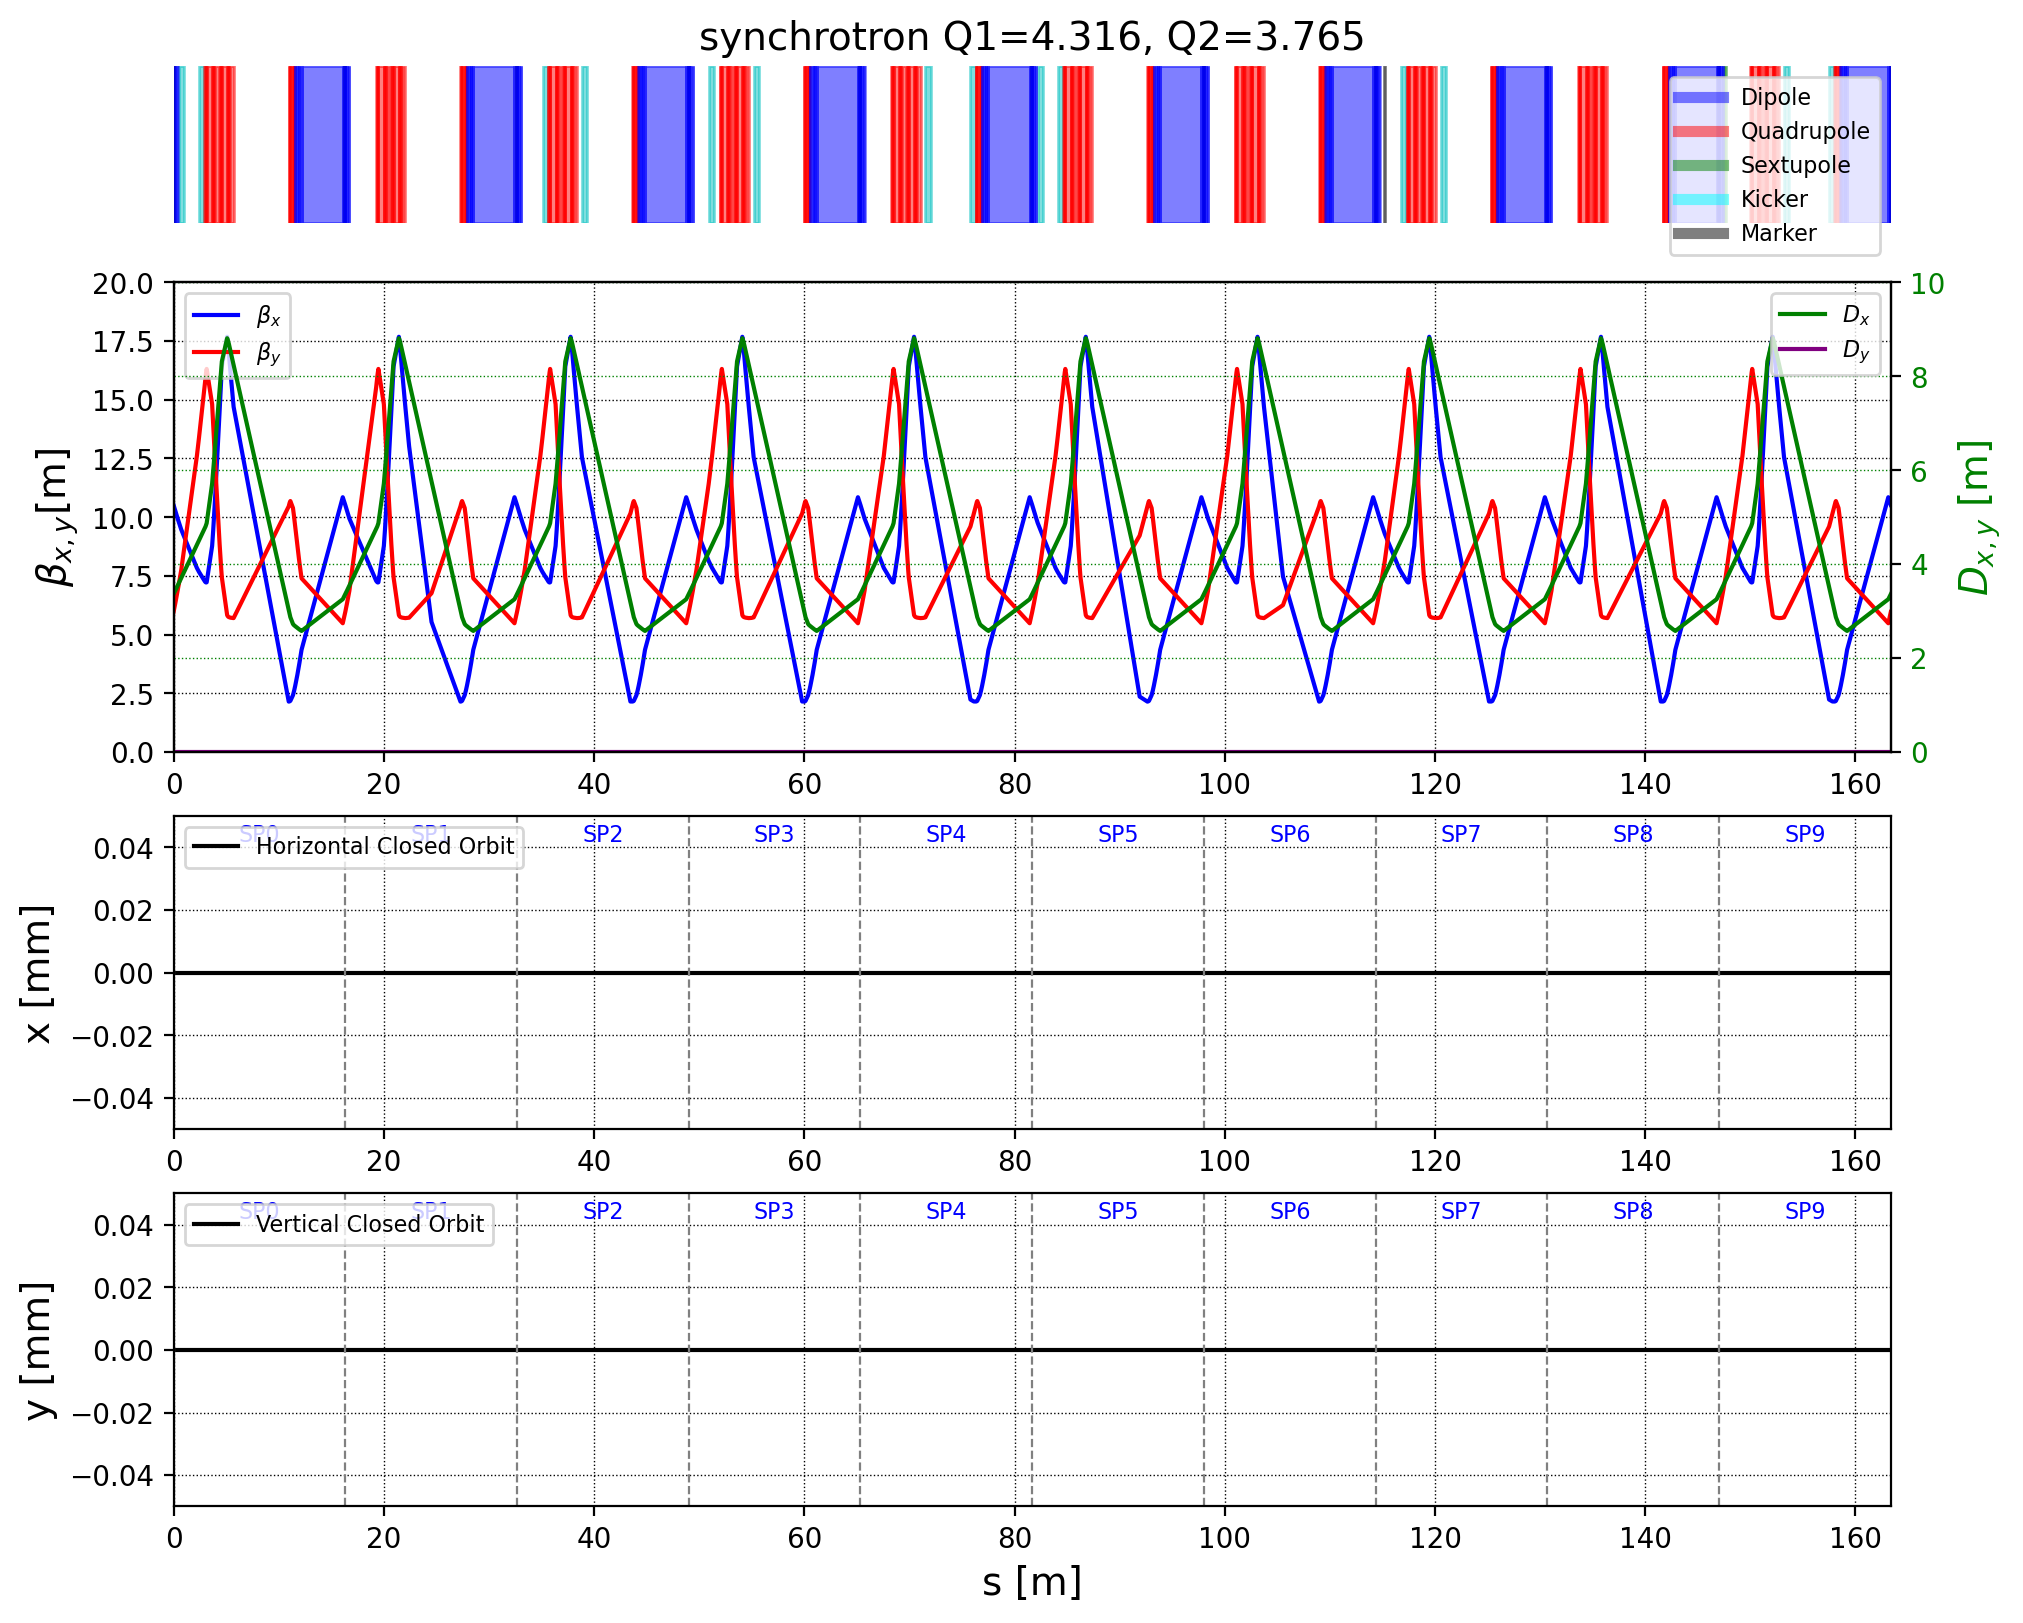

In [22]:
cpymad_plot_CO_sp(madx, twiss_0, sequence_name, save_file=plot_folder+'/initial_lattice_CO.png')  

# 3. Load magnet misalignments 

In [23]:
df_misalignments = pd.read_csv("Measurement_Data/df_jan25_V_misalignments.txt", sep="\t")

error_table_builder = cpymad_ErrorTableBuilder(twiss_0)

error_table_builder.add_misalignments_from_dataframe(df_misalignments)

error_file = "jan25_vertical_misalignments.tfs"
error_table_builder.save_to_tfs(error_file, origin="JAN25")
error_table_builder.error_df

/tmp/ipykernel_239322/2376914490.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.error_df = pd.concat([self.error_df, pd.DataFrame([row_full])], ignore_index=True)


,NAME,DX,DY,DS,DPHI,DTHETA,DPSI,S
0,sp0_dipfr8,0.0,0.2080,0.0,0.0,0.0,-0.034363,0.160000
1,sp0_dipfr9,0.0,0.2080,0.0,0.0,0.0,-0.034363,0.360000
2,sp0_dipfr10,0.0,0.2080,0.0,0.0,0.0,-0.034363,0.390000
3,sp0_dipfr1,0.0,0.2080,0.0,0.0,0.0,-0.034363,158.602820
4,sp0_dipfr2,0.0,0.2080,0.0,0.0,0.0,-0.034363,158.802820
...,...,...,...,...,...,...,...,...
134,sp9_dipfr9,0.0,-0.4660,0.0,0.0,0.0,-0.018533,147.386538
135,sp9_dipfr10,0.0,-0.4660,0.0,0.0,0.0,-0.018533,147.416538
136,sp9_qd,0.0,0.3790,0.0,0.0,0.0,0.554804,150.696138
137,sp9_qf,0.0,0.1835,0.0,0.0,0.0,-0.189751,152.124638


### Now that the magnet misalignments are loaded, we must implement them in the simulation

In [24]:
cpymad_apply_and_check_error_table(madx, error_file, error_table_builder.error_df)

True

### Plot the Bare Inferred Orbit (orbit with magnet misalignments but no correctors)

In [25]:
twiss_ibo = cpymad_madx_twiss_nocheck(madx, cpymad_logfile, sequence_name)

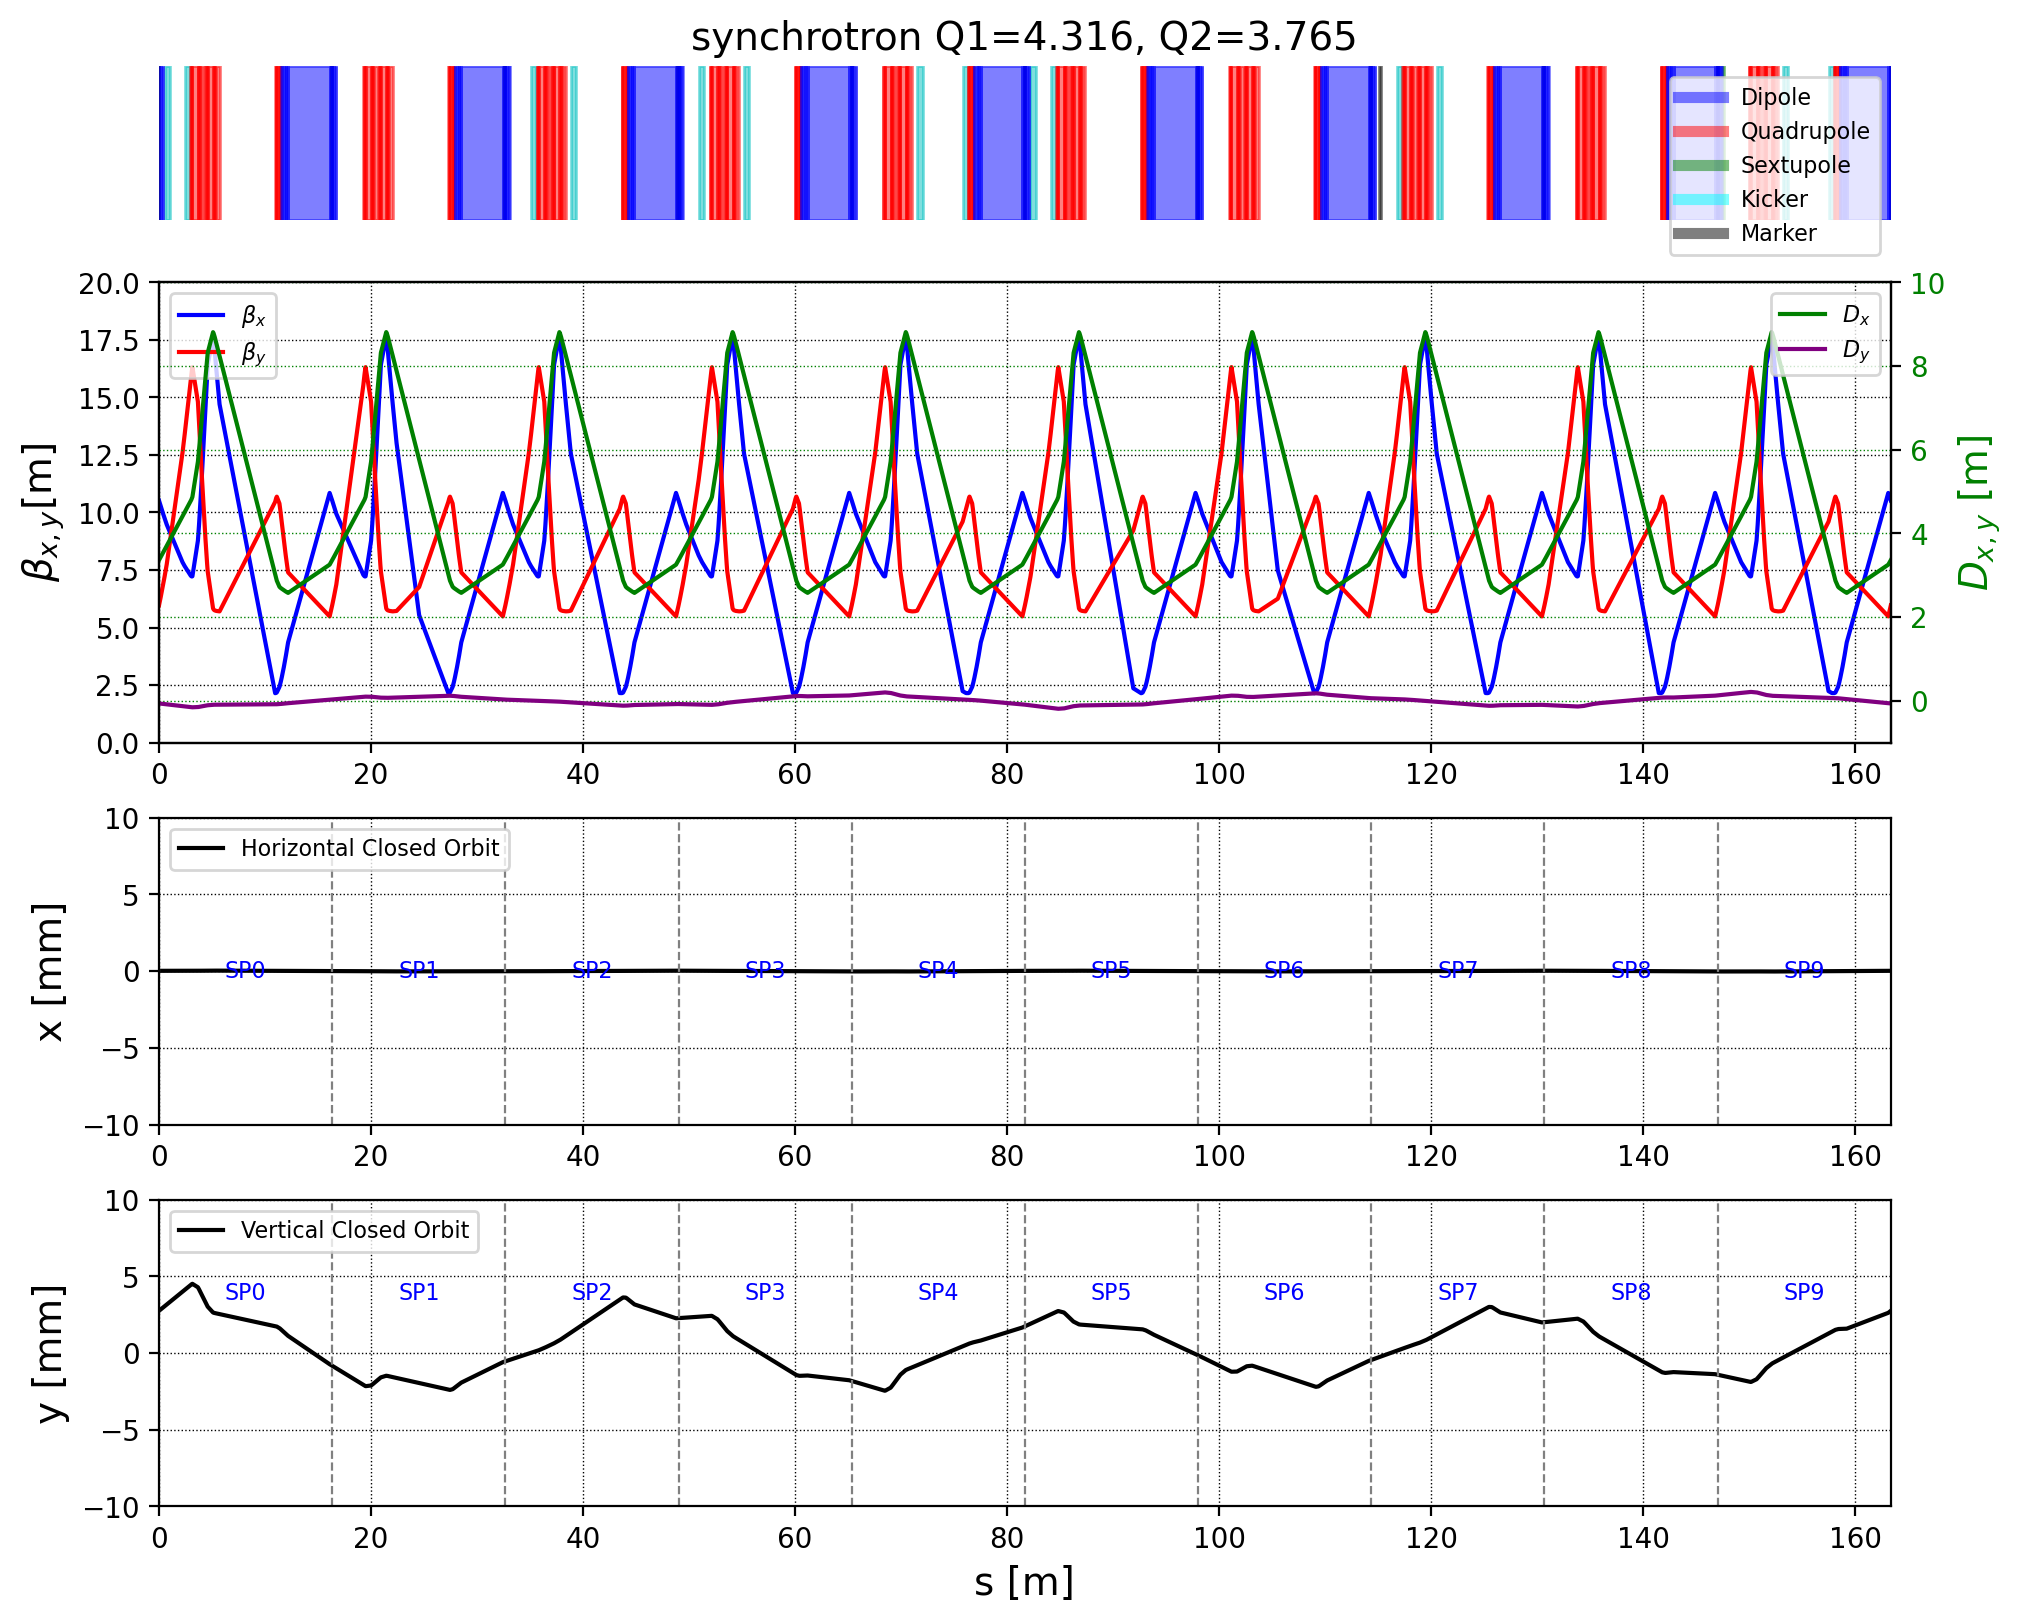

In [26]:
cpymad_plot_CO_sp(madx, twiss_ibo, sequence_name, save_file=(plot_folder+'/jan_25_V_misalignments.png'))

# 5. Correct orbit using MAD-X `Correct` command

### Make sure orbit correctors (in vertical plane) are switched off

In [27]:
v_corrector_currents_off = {
 'r0vd1_kick': 0,
 'r2vd1_kick': 0,
 'r3vd1_kick': 0,
 'r4vd1_kick': 0,
 'r5vd1_kick': 0,
 'r7vd1_kick': 0,
 'r9vd1_kick': 0}

In [28]:
cpymad_set_correctors(madx, cpymad_logfile, v_corrector_currents_off, max_E, cycle_time)

r0vd1_kick: 0.000000 A -> 0.000000 mrad
r2vd1_kick: 0.000000 A -> 0.000000 mrad
r3vd1_kick: 0.000000 A -> 0.000000 mrad
r4vd1_kick: 0.000000 A -> 0.000000 mrad
r5vd1_kick: 0.000000 A -> 0.000000 mrad
r7vd1_kick: 0.000000 A -> 0.000000 mrad
r9vd1_kick: 0.000000 A -> 0.000000 mrad


Make some file names to store `MAD-X` correction parameters

In [29]:
clist_file_x_m = 'clist_x_m_.dat'
clist_file_y_m = 'clist_y_m_.dat'
mlist_file_x_m = 'mlist_x_m_.dat'
mlist_file_y_m = 'mlist_y_m_.dat'        

clist_file_x = 'clist_x_.dat'
clist_file_y = 'clist_y_.dat'
mlist_file_x = 'mlist_x_.dat'
mlist_file_y = 'mlist_y_.dat'

In [30]:
# Turn on vertical correction kickers
madx.command.usekick(sequence=sequence_name, status="on", pattern="^R.*VD.*")

True

In [31]:
# Turn on monitors
madx.command.usemonitor(sequence=sequence_name, status="on", class_="monitor")

True

In [32]:
# Create twiss table for vertical orbit correction
bare_madx_twiss_file = sequence_name +'_madx_twiss_bare.tfs'
madx.input('set, format="12.12f"')
madx.input('select, flag=twiss, column=keyword, name, s, l, betx, alfx, mux, bety, alfy, muy, x, px, y, py, t, pt, dx, dpx, dy, dpy, wx, phix, dmux, wy, phiy, dmuy, ddx, ddpx, ddy, ddpy, r11, r12, r21, r22, energy, angle, k0l, k0sl, k1l, k1sl, k2l, k2sl, k3l, k3sl, k4l, k4sl, k5l, k5sl, k6l, k6sl, k7l, k7sl, k8l, k8sl, k9l, k9sl, k10l, k10sl, ksi, hkick, vkick, tilt, e1, e2, h1, h2, hgap, fint, fintx, volt, lag, freq, harmon, slot_id, assembly_id, mech_sep, kmax, kmin, calib, polarity, alfa, beta11, beta12, beta13, beta21, beta22, beta23, beta31, beta32, beta33, alfa11, alfa12, alfa13, alfa21, alfa22, disp1, disp2, disp3, disp4')
twiss_bare = madx.twiss(sequence=sequence_name, file=bare_madx_twiss_file, table='bare').dframe()

In [33]:
madx.command.correct(model='bare',sequence=sequence_name, plane="y", flag="ring", error=1e-7, mode='svd', cond=1, corzero=1, monerror=0, monscale=0, clist=clist_file_y, mlist=mlist_file_y)   

True

In [34]:
corrected_madx_twiss_file = sequence_name +'_madx_twiss_corrected_.tfs'
madx.input('set, format="12.12f"')
madx.input('select, flag=twiss, column=keyword, name, s, l, betx, alfx, mux, bety, alfy, muy, x, px, y, py, t, pt, dx, dpx, dy, dpy, wx, phix, dmux, wy, phiy, dmuy, ddx, ddpx, ddy, ddpy, r11, r12, r21, r22, energy, angle, k0l, k0sl, k1l, k1sl, k2l, k2sl, k3l, k3sl, k4l, k4sl, k5l, k5sl, k6l, k6sl, k7l, k7sl, k8l, k8sl, k9l, k9sl, k10l, k10sl, ksi, hkick, vkick, tilt, e1, e2, h1, h2, hgap, fint, fintx, volt, lag, freq, harmon, slot_id, assembly_id, mech_sep, kmax, kmin, calib, polarity, alfa, beta11, beta12, beta13, beta21, beta22, beta23, beta31, beta32, beta33, alfa11, alfa12, alfa13, alfa21, alfa22, disp1, disp2, disp3, disp4')
twiss_corrected = madx.twiss(sequence=sequence_name, file=corrected_madx_twiss_file, table='corrected').dframe()

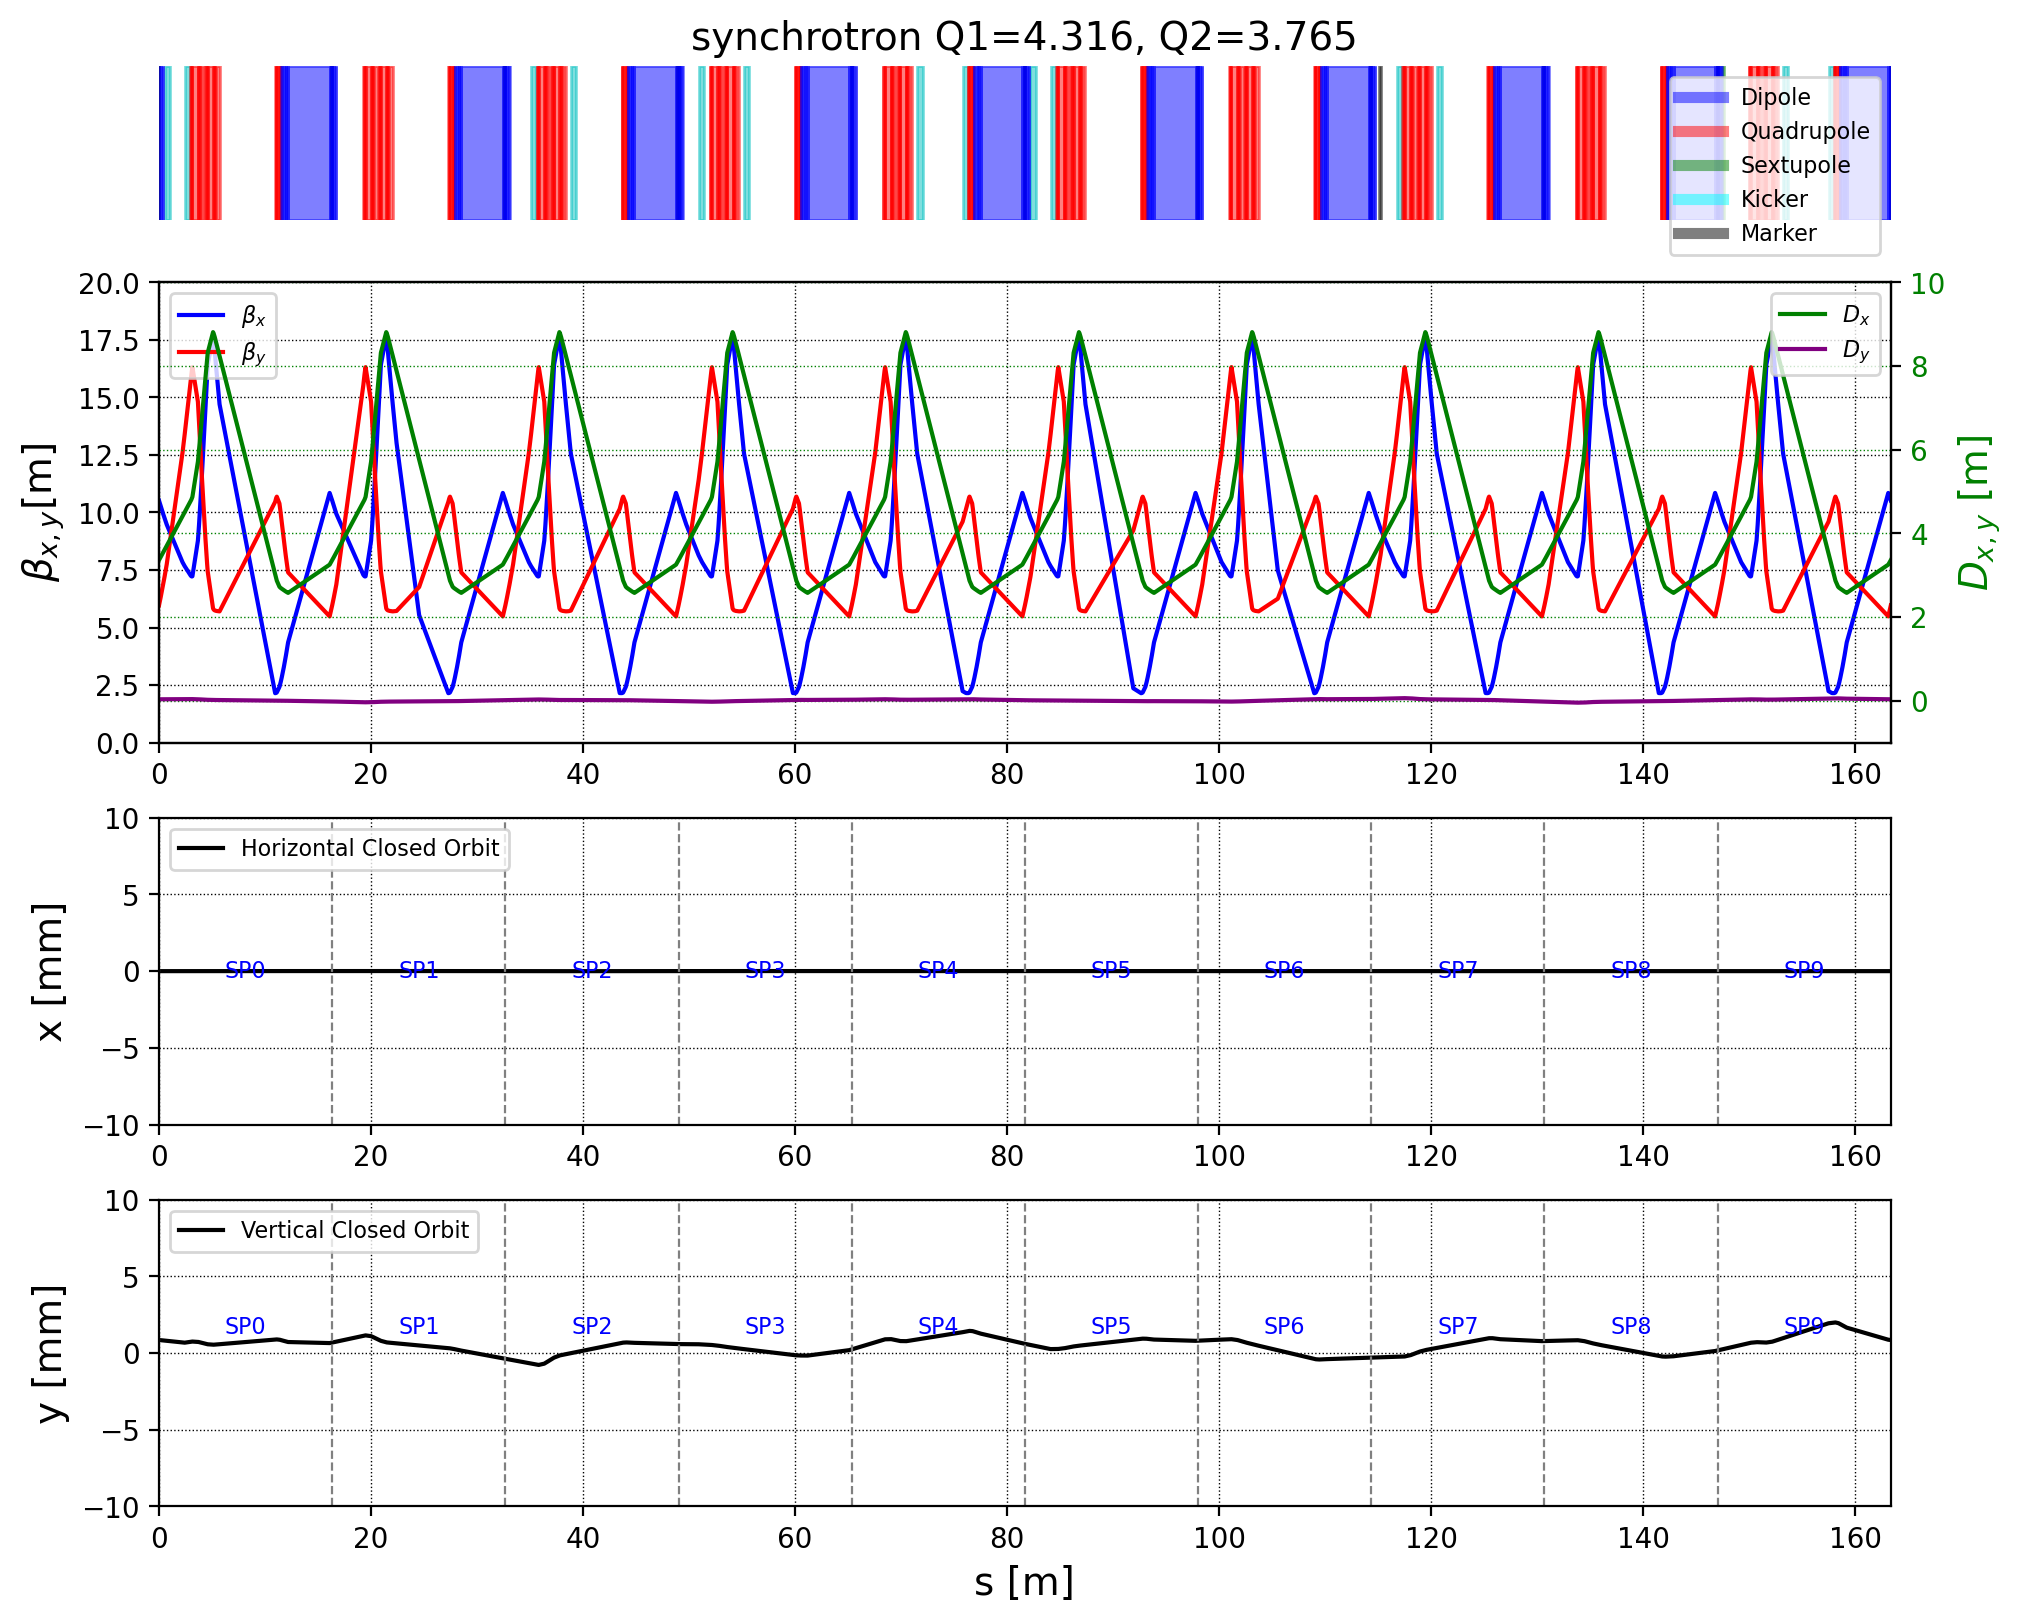

In [35]:
cpymad_plot_CO_sp(madx, twiss_corrected, sequence_name, save_file=(plot_folder+'/jan_25_V_misalignments_corrected.png'))

### Plot inferred bare orbit (IBO) vs corrected orbit

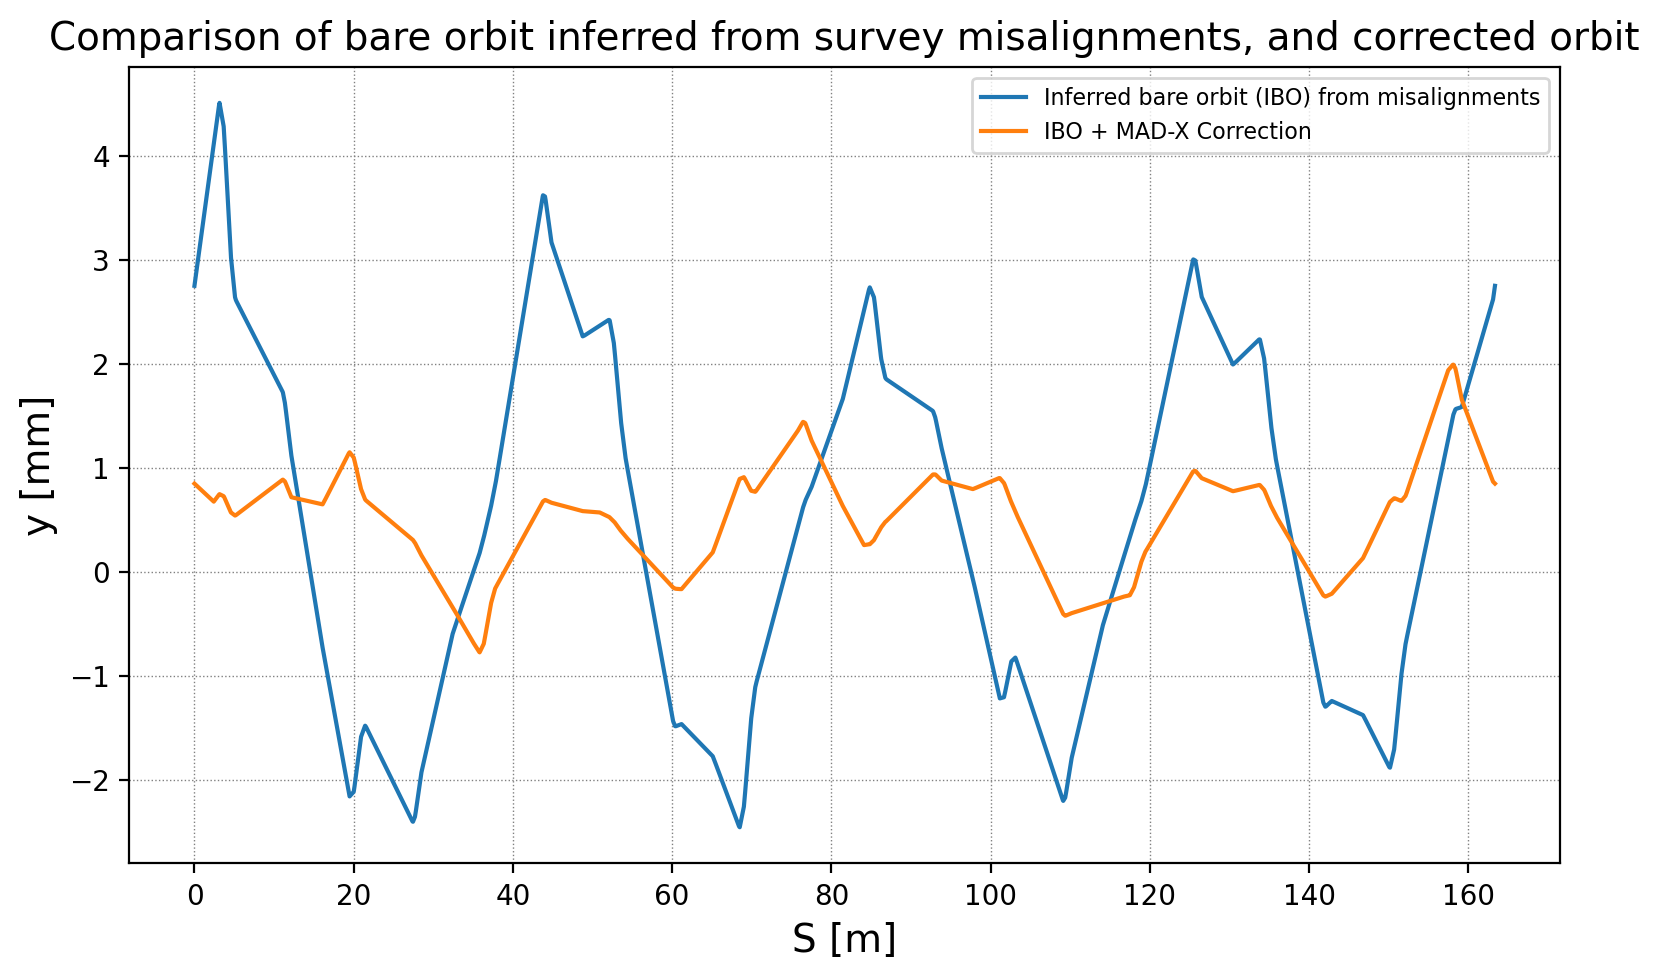

In [36]:
plt.plot(twiss_ibo.s, twiss_ibo.y*1e3, label='Inferred bare orbit (IBO) from misalignments');

plt.plot(twiss_corrected.s, twiss_corrected.y*1E3, label='IBO + MAD-X Correction');

plt.grid(which='both', ls=':', lw=0.5, color='grey');
plt.legend();
plt.title('Comparison of bare orbit inferred from survey misalignments, and corrected orbit');
plt.xlabel('S [m]')
plt.ylabel('y [mm]')
plt.tight_layout()  # Adjust layout for better spacing
plt.savefig(plot_folder+'/MADX_Correction_cf.png', bbox_inches='tight', dpi=300)  # Save with high resolution


## We see that `MAD-X` has set the vertical dipole correctors in order to minimise the closed orbit deviation

In [37]:
print ('Inferred Bare Orbit RMS = ', round_sig(np.std(twiss_ibo.y*1e3)), ' mm')

Inferred Bare Orbit RMS =  1.82  mm


In [38]:
print ('Inferred Bare Orbit plus Correction RMS = ', round_sig(np.std(twiss_corrected.y*1E3)), ' mm')

Inferred Bare Orbit plus Correction RMS =  0.547  mm


#### The kicks are stored to the file `clist_y.dat` we may extract and convert them to currents to be used in the GUI

In [39]:
v_corrector_currents = convert_kicks_to_currents(df_to_correction_dict(tfs.read_tfs('clist_y_.dat'), plane='v'))

In [40]:
v_corrector_currents

{'r0vd1_kick': np.float64(4.690629),
 'r2vd1_kick': np.float64(0.2274901),
 'r3vd1_kick': np.float64(-0.7089963),
 'r4vd1_kick': np.float64(0.6453303),
 'r5vd1_kick': np.float64(3.534259),
 'r7vd1_kick': np.float64(-0.1651155),
 'r9vd1_kick': np.float64(-3.658379)}

#### Close the MAD-X object to free up memory

In [41]:
madx.quit()